# Sentiment Analysis


All step we will do:
- Loading Imdb dataset using Hugging Face API
- EDA (Exploratory Data Analysis)
- Data Preprocessing
- Word Embedding: we will use Glove Embedding to build embedding matrix base on trained vocabluary
- Simple Neutral Network
- Convolutional Neural Network
- Long Short Term Memory Network
- Save models
- Predict on Amazon review data

## Loading Dataset

using Hugging Face API to get imdb dataset

In [ ]:
!pip install datasets
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 7.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.0 MB/s eta 0:00:00


Load the dataset

In [ ]:
import datasets
#Load dataset
data = datasets.load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
raw_data = pd.DataFrame(data['train'])
raw_data = pd.concat([raw_data, pd.DataFrame(data['test'])], axis=0, ignore_index=True)

Import essential libraries

In [ ]:
#import essential libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from keras.preprocessing.text import Tokenizer, one_hot
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPool1D, Embedding, Conv1D, LSTM
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split

## EDA (Exploratory Data Analysis)

In [ ]:
raw_data

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
49995,Just got around to seeing Monster Man yesterda...,1
49996,I got this as part of a competition prize. I w...,1
49997,I got Monster Man in a box set of three films ...,1
49998,"Five minutes in, i started to feel how naff th...",1


In [ ]:
raw_data.shape

(50000, 2)

Let's see how the dataset looks like

In [ ]:
def data_info(df: pd.DataFrame):
  print(f'description of dataset:\n',df.describe())
  print(f"Null of dataset:\n",df.isnull().sum())
  print("length of dataset:",len(df))
  print('duplicate of dataset:',df.duplicated().sum())
  print(f'Max lenght of review:', df['text'].str.len().max())
  print(f'data body:\n',df.head())

In [ ]:
data_info(raw_data)

description of dataset:
               label
count  50000.000000
mean       0.500000
std        0.500005
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Null of dataset:
 text     0
label    0
dtype: int64
length of dataset: 50000
duplicate of dataset: 418
Max lenght of review: 13704
data body:
                                                 text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


That is nice to know test and validate set have none of duplicated data points and null value. Now take a look at label distribution of each set

In [ ]:
from pandas.core.strings.accessor import str_extractall
import matplotlib.pyplot as plt
import seaborn as sns
#2 plot of data
def plot_data(df, name = None):
  colors = sns.color_palette()
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
  ax1.pie(df['label'].value_counts(), labels=df['label'].unique(),autopct='%1.1f%%', colors =colors[:3]);
  #ax2.hist(df['label']);
  sns.countplot(x='label', data=df);

  ax2.set_xlabel('Sentiment');
  ax2.set_ylabel('Frequency');

  ax1.set_title('Distribution');
  ax2.set_title('Distribution');
  if (name != None):
    fig.suptitle(name);

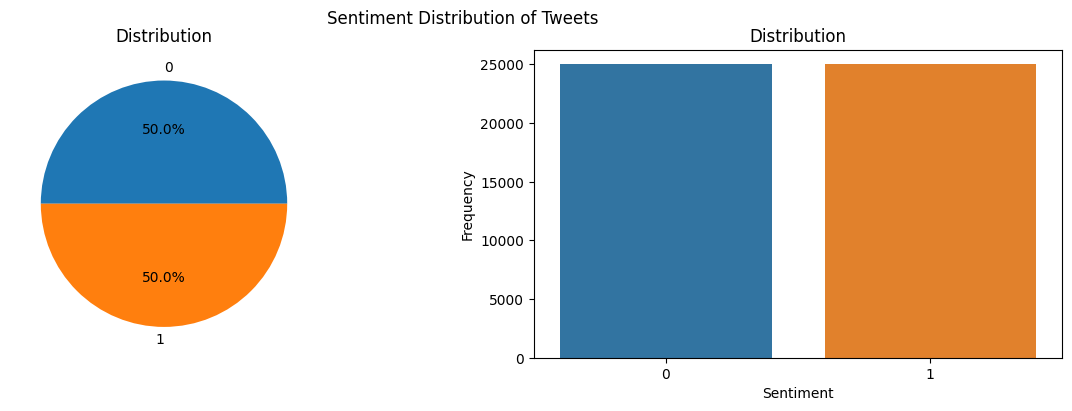

In [ ]:
plot_data(raw_data, 'Sentiment Distribution of Tweets')

## Data Preprocessing

### Data Cleaning

This is a sample of reviews

In [ ]:
raw_data['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_abb(text):
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don't", "do not", text)
    text= re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don't", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not",text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)
    text = re.sub(r"don't", "do not", text)
    return text

In [ ]:
def cleaning_text(text):
  '''clean up text'''
  text = text.lower()

  #remove html tags
  Tag_re = re.compile(r'<[^>]+>')
  text  = Tag_re.sub(' ', text)

  #change abbreviated into full words
  text = remove_abb(text)

  #remove punctuations and numbers
  text = re.sub(r'[^a-zA-Z]', ' ', text)

  #Single character removal
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

  #remove multiple spaces
  text = re.sub(r'\s+', ' ', text)

  #remove stopwords
  stopwords_list = [word for word in stopwords.words('english') if word != 'not']
  pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
  text = pattern.sub('', text)

  return text

In [ ]:
# cleaning reviews
import tqdm
reviews = list(raw_data['text'])
for i in tqdm.tqdm(range(len(reviews))):
  reviews[i] = cleaning_text(reviews[i])

100%|██████████| 50000/50000 [00:46<00:00, 1068.56it/s]


Let's see our reviews after cleaning up

In [ ]:
reviews[0]

'rented curious yellow video store controversy surrounded first released also heard first seized customs ever tried enter country therefore fan films considered controversial really see plot centered around young swedish drama student named lena wants learn everything life particular wants focus attentions making sort documentary average swede thought certain political issues vietnam war race issues united states asking politicians ordinary denizens stockholm opinions politics sex drama teacher classmates married men kills curious yellow years ago considered pornographic really sex nudity scenes far even not shot like cheaply made porno countrymen mind find shocking reality sex nudity major staple swedish cinema even ingmar bergman arguably answer good old boy john ford sex scenes films commend filmmakers fact sex shown film shown artistic purposes rather shock people make money shown pornographic theaters america curious yellow good film anyone wanting study meat potatoes pun intended

Then split the dataset into train and validate set

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(reviews, np.array(raw_data['label']), test_size=0.2, random_state=42)

In [ ]:
print("X_train:", len(X_train))
print("X_test:", len(X_test))
print("y_train:", len(y_train))
print("y_test:", len(y_test))

X_train: 40000
X_test: 10000
y_train: 40000
y_test: 10000


### Word Embedding

Embedding layer convert textual data into numeric form. Then be used as the first layer for deep learning model in Keras. We will use pre-trained word embeddings Glove

At first, we need to tokenize the reviews and convert to numeric form coresponding to the integer value in vocabulary

In [ ]:
# Using Tokenizer from keras.preprocessing.text
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train) #train the tokenizer

# Convert to numeric form
X_train = word_tokenizer.texts_to_sequences(X_train) # convert X_train to numeric form
X_test = word_tokenizer.texts_to_sequences(X_test)

Then compute the vocabulary size. It is the word_index + 1

In [ ]:
vocab_size = len(word_tokenizer.word_index) + 1
vocab_size

90767

We need to pad the reviews to the same length by adding 0 to the review which has length less than `maxlen` or eliminate the reviews which have length more than `maxlen`. We choose `maxlen = 100` cause we want it will fit with Glove word Embedding (which also have 100 dimensions for each word)

We can use the pad_sequences function of keras.preprocessing.sequence module

In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

We will use Glove word Embedding in `a2_glove.6B.100d.txt`. Now lets load it in Embedd dictionary

In [ ]:
import numpy as np
embedd_dict = dict()
with open('glove.6B.100d.txt', 'r') as file:
  for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedd_dict[word] = coefs

In [ ]:
len(embedd_dict)

400000

Then create our embedding matrix for our vocabulary using the embedding dictionary above

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in word_tokenizer.word_index.items():
  embedding_vector = embedd_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(90767, 100)

Can see all of words in our vocabulary are matched with Glove Embedding. Then move on to build our model

## Modeling

### Neutral Network

We will buile a simple neutral network and add an embedding layer to it. This simple model would have `Flatten` layer to flatten input data into 1D vevtor and `Dense` layer with 1 neuron and `sigmoid` activation (binary classification). This layer will return a result in range 0 and 1. If output close to 0, it indicates class 0 and class 1 consistently.

In [ ]:
# Simple Neutral Network

simple_nn_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen, trainable=False)

#adding embedding layer into the model
simple_nn_model.add(embedding_layer)

#adding flatten and Dense layer
simple_nn_model.add(Flatten()) #flatten data into 1D vector
simple_nn_model.add(Dense(1, activation='sigmoid'))

simple_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

we will optimeze the model by using `adam` optimizer and `binary_crossentropy` loss for measuring how well our model is performing during training

In [ ]:
print(simple_nn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9076700   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,086,701
Trainable params: 10,001
Non-trainable params: 9,076,700
_________________________________________________________________
None


Now let's train the model with 7 epochs

In [ ]:
simple_nn_history = simple_nn_model.fit(X_train, y_train, batch_size=256, epochs=7, validation_split=0.2, verbose=1)

Epoch 1/7
125/125 [==============================] - 2s 11ms/step - loss: 0.5766 - accuracy: 0.6949 - val_loss: 0.5101 - val_accuracy: 0.7514
Epoch 2/7
125/125 [==============================] - 1s 8ms/step - loss: 0.4648 - accuracy: 0.7855 - val_loss: 0.4972 - val_accuracy: 0.7629
Epoch 3/7
125/125 [==============================] - 1s 8ms/step - loss: 0.4244 - accuracy: 0.8096 - val_loss: 0.5010 - val_accuracy: 0.7623
Epoch 4/7
125/125 [==============================] - 1s 9ms/step - loss: 0.4018 - accuracy: 0.8223 - val_loss: 0.4945 - val_accuracy: 0.7640
Epoch 5/7
125/125 [==============================] - 1s 10ms/step - loss: 0.3843 - accuracy: 0.8315 - val_loss: 0.5027 - val_accuracy: 0.7602
Epoch 6/7
125/125 [==============================] - 2s 12ms/step - loss: 0.3713 - accuracy: 0.8403 - val_loss: 0.5082 - val_accuracy: 0.7621
Epoch 7/7
125/125 [==============================] - 1s 8ms/step - loss: 0.3616 - accuracy: 0.8440 - val_loss: 0.5250 - val_accuracy: 0.7548


In [ ]:
# Test prediction and evaluation

simple_nn_score = simple_nn_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.5289 - accuracy: 0.7611


In [ ]:
print("Test score:", simple_nn_score[0])
print("Test accuracy:", simple_nn_score[1])

Test score: 0.5289159417152405
Test accuracy: 0.7610999941825867


In [ ]:
def plot_evaluation(history_model):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
  ax1.plot(history_model.history['accuracy'])
  ax1.plot(history_model.history['val_accuracy'])
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'test'], loc='upper left')
  ax1.grid()

  ax2.plot(history_model.history['loss'])
  ax2.plot(history_model.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'test'], loc='upper left')
  ax2.grid()
  plt.show()


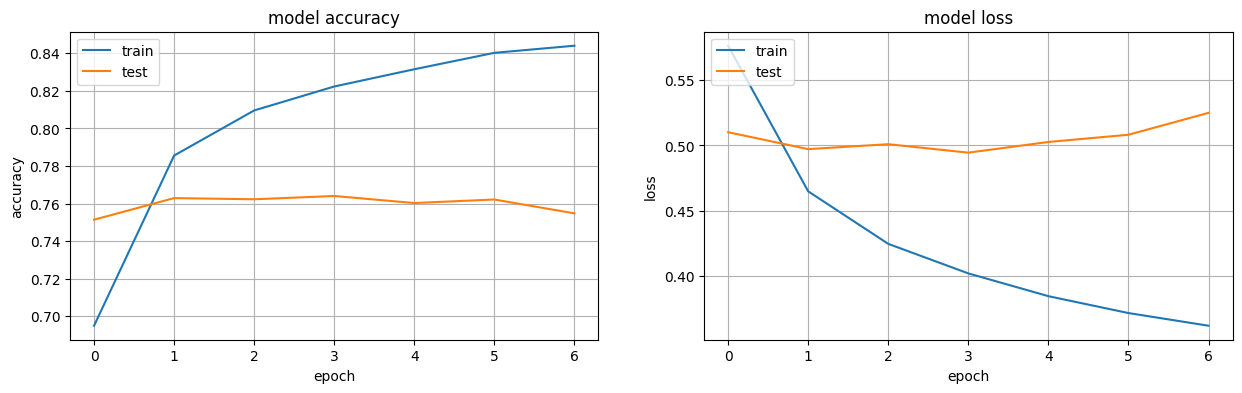

In [ ]:
plot_evaluation(simple_nn_history)

It looks like our model is overfitting, it performed well on training set but not on test set. Accuracy is lower too much on test set than training set and loss is higher as well. Let move to CNN which more complex model to see how does it perform

### Convolutional Neural Network (CNN)

we will use one dimensional Convolutional Neural Network for text classification.

At first, we still add embedding layer then:
- add Convolutional layer: The Conv1D slide a small window (kernel size) across the input sequences, applying convolutional operations to capture local patterns and features.
- add Max pooling layer (GlobalMaxPooling1D): The MaxPooling1D layer reduces the dimensionality of output and retain the most relevant features.
- Finally, add a dense layer with 1 neuron and `sigmoid` activation perform the final classification by learning higher-level representations from the extracted features.

In [ ]:
#Convolutional Neural Network 1D
cnn_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

# adding convolutional layer
cnn_model.add(Conv1D(128, 5, activation='relu')) #128 filters, kernel size 5, activation relu

# adding max pooling layer
cnn_model.add(GlobalMaxPool1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9076700   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,140,957
Trainable params: 64,257
Non-trainable params: 9,076,700
_________________________________________________________________
None


In [ ]:
cnn_history = cnn_model.fit(X_train, y_train, batch_size=256, epochs=7, validation_split=0.2, verbose=1)

Epoch 1/7
125/125 [==============================] - 26s 204ms/step - loss: 0.5204 - accuracy: 0.7393 - val_loss: 0.4118 - val_accuracy: 0.8176
Epoch 2/7
125/125 [==============================] - 25s 196ms/step - loss: 0.3666 - accuracy: 0.8432 - val_loss: 0.3753 - val_accuracy: 0.8330
Epoch 3/7
125/125 [==============================] - 28s 222ms/step - loss: 0.3134 - accuracy: 0.8714 - val_loss: 0.3461 - val_accuracy: 0.8496
Epoch 4/7
125/125 [==============================] - 24s 195ms/step - loss: 0.2739 - accuracy: 0.8923 - val_loss: 0.3457 - val_accuracy: 0.8462
Epoch 5/7
125/125 [==============================] - 25s 201ms/step - loss: 0.2427 - accuracy: 0.9097 - val_loss: 0.3355 - val_accuracy: 0.8547
Epoch 6/7
125/125 [==============================] - 25s 201ms/step - loss: 0.2126 - accuracy: 0.9262 - val_loss: 0.3369 - val_accuracy: 0.8515
Epoch 7/7
125/125 [==============================] - 25s 201ms/step - loss: 0.1868 - accuracy: 0.9387 - val_loss: 0.3260 - val_accuracy:

In [ ]:
cnn_score = cnn_model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 14ms/step - loss: 0.3387 - accuracy: 0.8557


In [ ]:
print("Test score:", cnn_score[0])
print("Test accuracy:", cnn_score[1])

Test score: 0.33869537711143494
Test accuracy: 0.8557000160217285


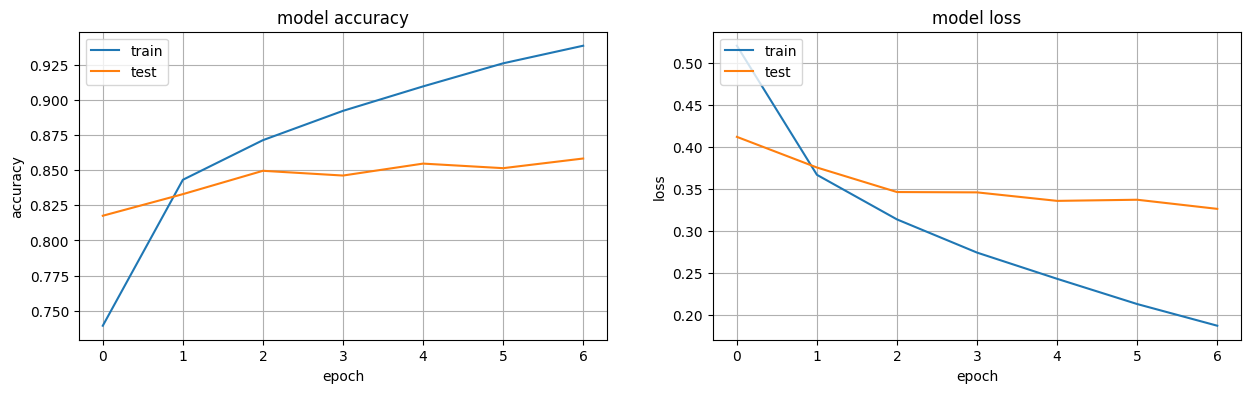

In [ ]:
plot_evaluation(cnn_history)

It look like better than simple neural network. The curve of both accuracy and loss on testing set fitter with curve of training set. Its mean that this model performs better than simple neural network. But it is still overfitting. Accuracy on test set just around 85% while above 92% in traing set.

 Lets move to next model to see whether it better than this.

### Long Short Term Memory (LSTM)

LSTM (Long Short-Term Memory) is a type of neural network designed for sequential data. It's great for sentiment analysis because it understands word order, captures context, and works with variable-length text. LSTMs automatically learn important patterns for sentiment prediction, making them powerful for natural language processing tasks.

To build our LSTM model, we still do the same but adding LSTM layer after embedding layer

In [ ]:
#LSTM
LSTM_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen, trainable=False)
LSTM_model.add(embedding_layer)

# adding LSTM layer
LSTM_model.add(LSTM(128)) #don't need to set return_sequences

# adding dense layer
LSTM_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(LSTM_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9076700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,194,077
Trainable params: 117,377
Non-trainable params: 9,076,700
_________________________________________________________________
None


In [ ]:
LSTM_history = LSTM_model.fit(X_train, y_train, batch_size=256, epochs=7, validation_split=0.2, verbose=1)

Epoch 1/7
125/125 [==============================] - 76s 583ms/step - loss: 0.5284 - accuracy: 0.7342 - val_loss: 0.4300 - val_accuracy: 0.8016
Epoch 2/7
125/125 [==============================] - 72s 577ms/step - loss: 0.4289 - accuracy: 0.8076 - val_loss: 0.3931 - val_accuracy: 0.8254
Epoch 3/7
125/125 [==============================] - 74s 590ms/step - loss: 0.3952 - accuracy: 0.8273 - val_loss: 0.3759 - val_accuracy: 0.8330
Epoch 4/7
125/125 [==============================] - 73s 587ms/step - loss: 0.3605 - accuracy: 0.8455 - val_loss: 0.3521 - val_accuracy: 0.8503
Epoch 5/7
125/125 [==============================] - 70s 557ms/step - loss: 0.3352 - accuracy: 0.8542 - val_loss: 0.3352 - val_accuracy: 0.8604
Epoch 6/7
125/125 [==============================] - 72s 580ms/step - loss: 0.3164 - accuracy: 0.8667 - val_loss: 0.3248 - val_accuracy: 0.8656
Epoch 7/7
125/125 [==============================] - 73s 589ms/step - loss: 0.3019 - accuracy: 0.8722 - val_loss: 0.3217 - val_accuracy:

In [ ]:
LSTM_score = LSTM_model.evaluate(X_test, y_test)

313/313 [==============================] - 19s 61ms/step - loss: 0.3247 - accuracy: 0.8604


In [ ]:
print("Test score:", LSTM_score[0])
print("Test accuracy:", LSTM_score[1])

Test score: 0.32469335198402405
Test accuracy: 0.8604000210762024


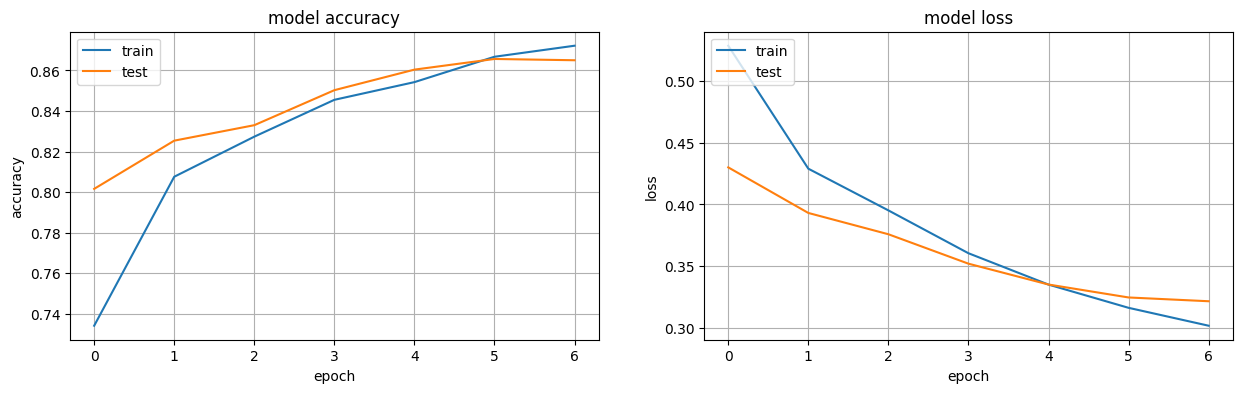

In [ ]:
plot_evaluation(LSTM_history)

The model best fit with the data, both loss curve and accuracy curve on testing set really nice, it both bending almost the same with curve of training set. Moreover, accuracy is really high, above 86% and as the result, loss would be very low (under 33%)

## Save model

Then, we can combine our models and related object for later use

In [ ]:
import pickle as pk

pk.dump(word_tokenizer, open('./models/word_tokenizer.pkl', 'wb'))
cnn_model.save('./models/CNN_model.h5')
LSTM_model.save('./models/LSTM_model.h5')
simple_nn_model.save('./models/SNN_model.h5')

## Predict on unsupervised data

We will use data of Amazon review on `Gift Card`. Lets see how it is

In [ ]:
amz_gif = datasets.load_dataset('amazon_us_reviews', 'Gift_Card_v1_00')

Generating train split:   0%|          | 0/149086 [00:00<?, ? examples/s]

Dataset amazon_us_reviews downloaded and prepared to /root/.cache/huggingface/datasets/amazon_us_reviews/Gift_Card_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
amz_data = pd.DataFrame(amz_gif['train'])[['review_headline', 'review_body', 'star_rating']]

In [ ]:
amz_data

,review_headline,review_body,star_rating
0,Five Stars,Great birthday gift for a young adult.,5
1,Gift card for the greatest selection of items ...,It's an Amazon gift card and with over 9823983...,5
2,Five Stars,Good,5
3,One Star,Fair,1
4,Five Stars,I can't believe how quickly Amazon can get the...,5
...,...,...,...
149081,Way easier than explaining your musical taste ...,Finally there is a way for your family to buy ...,5
149082,itunes paid for,its very convenient to have an idea of how mut...,4
149083,Way easier than explaining your musical taste ...,Finally there is a way for your family to buy ...,5
149084,A great way to turn cash into songs,I picked up a few of these at Target a while b...,4


- 5 stars mean really good and closest to class 1 (range 0.8 to 1)
- 4 stars mean good but lower a bit (range 0.6 to 0.8)
- 3 stars mean average (range 0.4 to 0.6)
- 2 stars mean bad (range 0.2 to 0.4)
- 1 stars mean really bad (range 0 to 0.2)

The range coresponds to result of model predicting

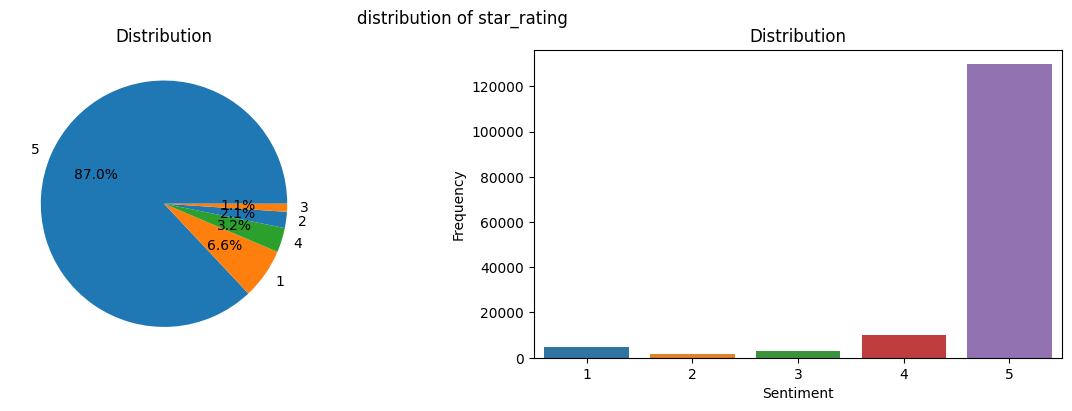

In [ ]:
plot_data(amz_data.rename(columns={'star_rating':'label'}), 'distribution of star_rating')

In [ ]:
def predict_data(corpus: list, model):
  review = [cleaning_text(text) for text in corpus]
  review = word_tokenizer.texts_to_sequences(review)
  review = pad_sequences(review, padding='post', maxlen=maxlen)

  if model == "CNN":
    return cnn_model.predict(review)
  if model == "LSTM":
    return LSTM_model.predict(review)
  elif model == "SNN":
    return simple_nn_model.predict(review)

In [ ]:
amz_data['prediction_SNN'] = predict_data(amz_data['review_body'], 'SNN')

4659/4659 [==============================] - 9s 2ms/step


In [ ]:
amz_data['prediction_LSTM'] = predict_data(amz_data['review_body'], 'LSTM')

4659/4659 [==============================] - 300s 64ms/step


In [ ]:
amz_data['prediction_CNN'] = predict_data(amz_data['review_body'], 'CNN')

4659/4659 [==============================] - 56s 12ms/step


In [ ]:
amz_data

,review_headline,review_body,star_rating,prediction_SNN,prediction_LSTM,prediction_CNN
0,Five Stars,Great birthday gift for a young adult.,5,0.825074,0.983466,0.986020
1,Gift card for the greatest selection of items ...,It's an Amazon gift card and with over 9823983...,5,0.594105,0.868383,0.775147
2,Five Stars,Good,5,0.585275,0.701787,0.773392
3,One Star,Fair,1,0.517647,0.615710,0.689593
4,Five Stars,I can't believe how quickly Amazon can get the...,5,0.570657,0.857455,0.962035
...,...,...,...,...,...,...
149081,Way easier than explaining your musical taste ...,Finally there is a way for your family to buy ...,5,0.669032,0.733007,0.721312
149082,itunes paid for,its very convenient to have an idea of how mut...,4,0.581894,0.599569,0.541496
149083,Way easier than explaining your musical taste ...,Finally there is a way for your family to buy ...,5,0.656399,0.668611,0.708977
149084,A great way to turn cash into songs,I picked up a few of these at Target a while b...,4,0.693648,0.558023,0.154265


Can see that our model result really close to real star_rating. Our model worked well.

Each model have its own advantages and disadvantages. The most important thing is how we use them to solve out problems in real life

## References

[Pre-trained word embedding using glove in nlp models](https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/)

[Sentiment Analysis with NLP & Deep Learning](https://www.analyticsvidhya.com/blog/2022/02/sentiment-analysis-with-nlp-deep-learning/)
